# Local optimization applied to the pixel travel map solution

This notebook shows how to improve a path by local optimization.

In [42]:
import matplotlib.pyplot as plt
from matplotlib import animation, ticker, rc, patches
import matplotlib.collections as mc
import numpy as np
import pandas as pd
from functools import *
from itertools import *
from pathlib import Path
from PIL import Image
import math, pickle, os
from colorama import Fore, Back, Style
from tqdm import tqdm

# Functions to map between cartesian coordinates and one-dimensional array indexes
def cartesian_to_array(x, y, shape=(257,257,3)):
    """Transforms integer coordinates into array indices"""
    m, n = shape[:2]
    i = (n - 1) // 2 - y
    j = (n - 1) // 2 + x
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    return i, j


def array_to_cartesian(i, j, shape=(257,257,3)):
    m, n = shape[:2]
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    y = (n - 1) // 2 - i
    x = j - (n - 1) // 2
    return x, y


# Functions to map an image between array and record formats
def image_to_dict(image):
    """Convert a 3d array image into a dict of pair -> tuple)"""
    image = np.atleast_3d(image)
    kv_image = {}
    for i, j in product(range(len(image)), repeat=2):
        kv_image[array_to_cartesian(i, j, image.shape)] = tuple(image[i, j])
    return kv_image


def image_to_df(image):
    """Convert a 3d array image into a dataframe"""
    return pd.DataFrame(
        [(x, y, r, g, b) for (x, y), (r, g, b) in image_to_dict(image).items()],
        columns=['x', 'y', 'r', 'g', 'b']
    )


def df_to_image(df):
    """Convert a sorted dataframe into a 3d array image"""
    side = int(len(df) ** 0.5)  # assumes a square image
    return df.set_index(['x', 'y']).to_numpy().reshape(side, side, -1)


def get_position(config):
    """Convert a configuration (i.e., a list or a 2d array) into an integer position (i.e., a tuple or array)"""
    assert len(config) == 8
    return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))


# Functions to compute the cost function

# Cost of reconfiguring the robotic arm: the square root of the number of links rotated
def reconfiguration_cost(from_config, to_config):
    diffs = np.abs(np.asarray(from_config) - np.asarray(to_config)).sum(axis=1)
    if not (diffs <= 1).all():
#         print(f'illegal movement by {diffs} from {from_config.sum(axis=0)} to {to_config.sum(axis=0)}')
#         print(from_config)
#         print(to_config)
        return 1e6
#     assert diffs.sum() >= 1 # the configurations should not be equal
    assert (diffs <= 1).all(), (diffs, from_config, to_config)
    return np.sqrt(diffs.sum())


# Cost of moving from one color to another: the sum of the absolute change in color components
def color_cost(from_position, to_position, image, color_scale=3.0):
    """Color cost.
    
    Parameters
    ----------
    from_position, to_position: pairs of positive integers (output of cartesian_to_array)
    image: array of shape (257, 257, 3)"""
    assert type(from_position) == tuple
    return np.abs(image[to_position] - image[from_position]).sum() * color_scale


# Total cost of one step: the reconfiguration cost plus the color cost
def step_cost(from_config, to_config, image):
    """Total cost of one step
    
    Parameters:
    from_config, to_config: configurations (i.e., lists of arm pairs)"""
    from_position = cartesian_to_array(*get_position(from_config), image.shape)
    to_position = cartesian_to_array(*get_position(to_config), image.shape)
    return (
        reconfiguration_cost(from_config, to_config) +
        color_cost(from_position, to_position, image)
    )

# Compute total cost of path over image
def total_cost(path, image):
    return reduce(
        lambda cost, pair: cost + step_cost(pair[0], pair[1], image),
        zip(path[:-1], path[1:]),
        0,
    )

def plot_traj(points, image, difference_list=None, ax=None):
    """Plot the background image and the trajectory.
    
    Parameters:
    points: 2d array with points as rows (cartesian coordinates).
    image: 3d array"""

    if ax is None:
        fig = plt.figure(figsize=(9, 9))
        ax = fig.add_axes([0, 0, 1, 1])
    else:
        ax.axis('off')

    patch = patches.Polygon(points, edgecolor='k', linewidth=1,
                            closed=False, fill=False, antialiased=True)
    ax.add_patch(patch)
    
    radius = image.shape[0] // 2
    ax.matshow(image * 0.8 + 0.2, extent=(-radius-0.5, radius+0.5, -radius-0.5, radius+0.5))
    
    if difference_list is None:
        plt.arrow(-90, 90, -28, 28, width=3, alpha=0.8)
        ax.set_xlim(-128.5, -70.5)
        ax.set_ylim(70.5, 128.5)
    else:
        for c in difference_list:
            ax.add_patch(plt.Circle(c, radius=2, fill=False, edgecolor='r', linewidth=3, alpha=0.7))
        ax.set_xlim(-128.5, -70.5)
        ax.set_ylim(20.5, 128.5)
#         plt.savefig('differences-quiz.png', bbox_inches='tight')
        
    if ax is None:
        fig.show()
    
radius = 128
image = df_to_image(pd.read_csv('image.csv'))


We read the submission file of the [pixel travel map notebook](https://www.kaggle.com/code/starohub/pixel-travel-map-more-directions) and zoom in at the top left corner. The top left corner cannot be optimal. Why is the corner (-128, 128) a dead end? Why is there a diagonal step between (-127, 128) and (-128, 127)?

Path shape: (67095, 8, 2)


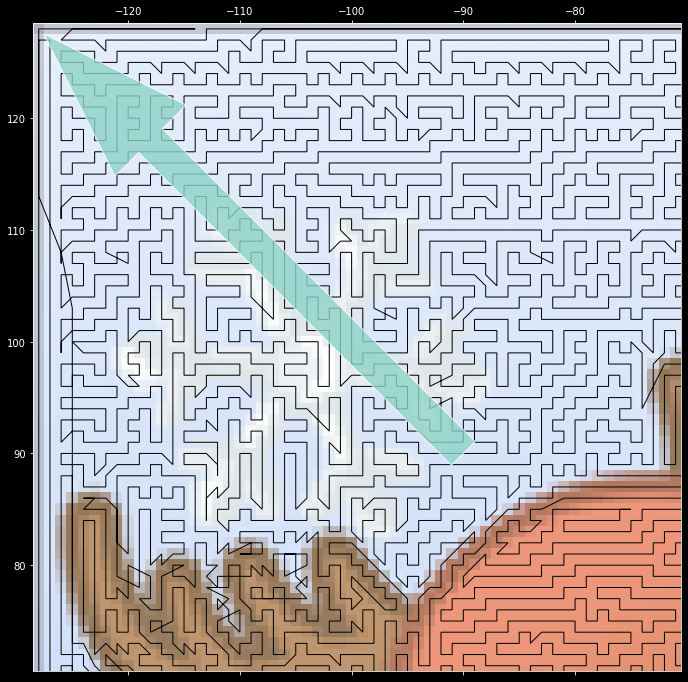

In [43]:
path = list(pd.read_csv('submission.csv')['configuration'])
path = np.array([[[int(s) for s in arm.split(' ')] for arm in c.split(';')] for c in path])
print('Path shape:', path.shape)
plot_traj(path.sum(axis=1), image)

# Manual update

Let's look at the data:

In [44]:
points = path.sum(axis=1)
# print('Points shape', points.shape)

# At what position is the top left corner in the path?
print('Corner position:', (points == np.array([[-128, 128]])).all(axis=1).argmax())

pd.DataFrame(points, columns = ['x', 'y'])[5075:5085]

Corner position: 59465


,x,y
5075,19,-128
5076,20,-128
5077,21,-128
5078,22,-128
5079,23,-128
5080,24,-128
5081,25,-128
5082,26,-128
5083,27,-128
5084,28,-128


It looks like exchanging positions 5079 and 5080 will shorten the path. Let's do it

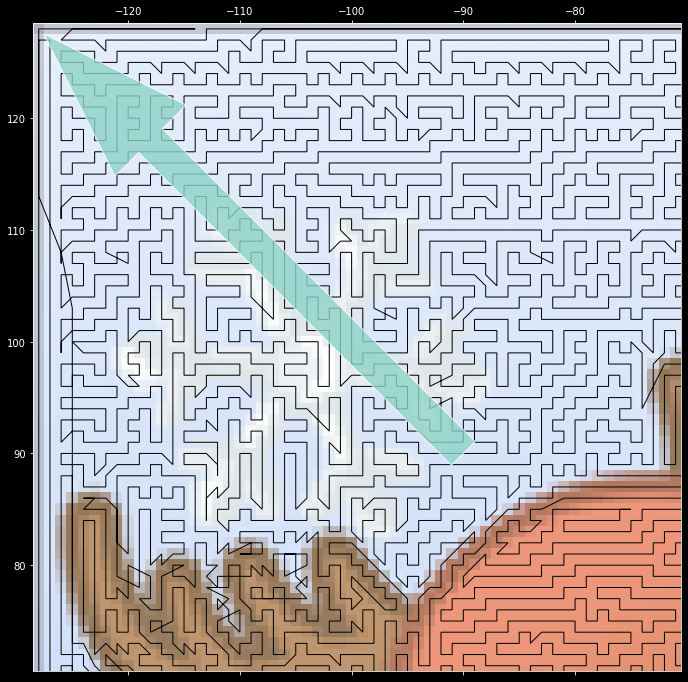

In [45]:
new_path = np.vstack([path[:5079], path[5080:5081], path[5079:5080], path[5081:]])
plot_traj(new_path.sum(axis=1), image)

In [46]:
def submit(path):
    def config_to_string(config):
        return ';'.join([' '.join(map(str, vector)) for vector in config])

    submission = pd.Series(
        [config_to_string(config) for config in path],
        name="configuration",
    )
    display(submission)
    cost = total_cost(path, image)
    submission.to_csv(f'{cost:.2f}_submission.csv', index=False, header=True)
    print(f"Total cost of saved path is {cost:.2f}")
    
submit(new_path)

0         64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
1        64 -1;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
2        64 -2;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
3        64 -3;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
4        64 -4;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
                            ...                    
67090     64 0;-32 4;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
67091     64 0;-32 3;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
67092     64 0;-32 2;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
67093     64 0;-32 1;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
67094     64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
Name: configuration, Length: 67095, dtype: object

Total cost of saved path is 2079096.91


# Automatic local optimization

You have seen how to improve the path by a local modification. Can we generalize and automate this operation? 

> Yes, we can!

A simple for loop suffices to test for every position $i$ whether we can replace the two edges $(v_i, v_{i+1})$ and $(v_{i+2}, v_{i+3})$ by new edges $(v_i, v_{i+2})$ and $(v_{i+1}, v_{i+3})$. This replacement is called a **2-opt move**.

The 2-opt move is much simpler to implement than the 4-opt move, which is used in the [recipe for getting below 76000](https://www.kaggle.com/competitions/santa-2022/discussion/376306).

For the implementation, I've adapted the cost function so that it returns 1E6 if the path contains impossible arm movements.

In [47]:
print(f'Cost before local optimization: {total_cost(path, image):.2f}')
optimized_path = path.copy()
difference_list = []

def optimize():
    """Optimizes optimized_path"""
    count = 0
    for i in tqdm(range(len(optimized_path) - 3)):
        current_cost = total_cost(optimized_path[i:i+4], image)
        new_cost = total_cost([optimized_path[i], optimized_path[i+2], optimized_path[i+1], optimized_path[i+3]], image)
        if new_cost < current_cost:
            optimized_path[i+1], optimized_path[i+2] = optimized_path[i+2].copy(), optimized_path[i+1].copy()
    #         print(i, current_cost - new_cost)
            count += 1
            difference_list.append(optimized_path[i:i+4].sum(axis=1).mean(axis=0))
    print(f'Cost after local optimization: {total_cost(optimized_path, image):.2f} (after {count} 2-opt moves)')

optimize()

# Let's do a second pass to be sure we haven't missed any optimization opportunity
print()
optimize()

# And a third pass
print()
optimize()

def optimize1():
    """Optimizes optimized_path"""
    count = 0
for i in tqdm(range(len(optimized_path) - 4)):
    current_cost = total_cost([optimized_path[i], optimized_path[i+1]], image)
    current_cost += total_cost([optimized_path[i+3], optimized_path[i+4]], image)
    new_cost = total_cost([optimized_path[i], optimized_path[i+3]], image)
    new_cost += total_cost([optimized_path[i+1], optimized_path[i+4]], image)
    if new_cost < current_cost:
        optimized_path[i+1], optimized_path[i+3] = optimized_path[i+3].copy(), optimized_path[i+1].copy()
#         print(i, current_cost - new_cost)
        count += 1
        difference_list.append(optimized_path[i:i+5].sum(axis=1).mean(axis=0))
print(f'Cost after local optimization: {total_cost(optimized_path, image):.2f} (after {count} 2-opt moves)')

print()
optimize1()

print()
optimize1()

print()
optimize1()
# Try another 2-opt move
print()
count = 0
for i in tqdm(range(len(optimized_path) - 4)):
    current_cost = total_cost([optimized_path[i], optimized_path[i+1]], image)
    current_cost += total_cost([optimized_path[i+3], optimized_path[i+4]], image)
    new_cost = total_cost([optimized_path[i], optimized_path[i+3]], image)
    new_cost += total_cost([optimized_path[i+1], optimized_path[i+4]], image)
    if new_cost < current_cost:
        optimized_path[i+1], optimized_path[i+3] = optimized_path[i+3].copy(), optimized_path[i+1].copy()
#         print(i, current_cost - new_cost)
        count += 1
        difference_list.append(optimized_path[i:i+5].sum(axis=1).mean(axis=0))
print(f'Cost after local optimization: {total_cost(optimized_path, image):.2f} (after {count} 2-opt moves)')

print()
count = 0

for i in tqdm(range(len(optimized_path) - 3)):
        current_cost = total_cost(optimized_path[i:i+4], image)
        new_cost = total_cost([optimized_path[i], optimized_path[i+2], optimized_path[i+1], optimized_path[i+3]], image)
        if new_cost < current_cost:
            optimized_path[i+1], optimized_path[i+2] = optimized_path[i+2].copy(), optimized_path[i+1].copy()
    #         print(i, current_cost - new_cost)
            count += 1
            difference_list.append(optimized_path[i:i+4].sum(axis=1).mean(axis=0))
print(f'Cost after local optimization: {total_cost(optimized_path, image):.2f} (after {count} 2-opt moves)')


print()
count = 0
for i in tqdm(range(len(optimized_path) - 4)):
    current_cost = total_cost([optimized_path[i], optimized_path[i+1]], image)
    current_cost += total_cost([optimized_path[i+3], optimized_path[i+4]], image)
    new_cost = total_cost([optimized_path[i], optimized_path[i+3]], image)
    new_cost += total_cost([optimized_path[i+1], optimized_path[i+4]], image)
    if new_cost < current_cost:
        optimized_path[i+1], optimized_path[i+3] = optimized_path[i+3].copy(), optimized_path[i+1].copy()
#         print(i, current_cost - new_cost)
        count += 1
        difference_list.append(optimized_path[i:i+5].sum(axis=1).mean(axis=0))
print(f'Cost after local optimization: {total_cost(optimized_path, image):.2f} (after {count} 2-opt moves)')

print()
optimize()

print()
optimize1()

print()
optimize()

print()
optimize1()

Cost before local optimization: 79098.91


100%|██████████| 67092/67092 [00:11<00:00, 6012.26it/s]


Cost after local optimization: 78989.09 (after 360 2-opt moves)



100%|██████████| 67092/67092 [00:11<00:00, 6046.87it/s]


Cost after local optimization: 78982.02 (after 18 2-opt moves)



100%|██████████| 67092/67092 [00:11<00:00, 6063.20it/s]


Cost after local optimization: 78981.57 (after 2 2-opt moves)


  1%|▏         | 946/67091 [00:00<00:07, 9030.87it/s]


TypeError: unsupported operand type(s) for +=: 'type' and 'int'

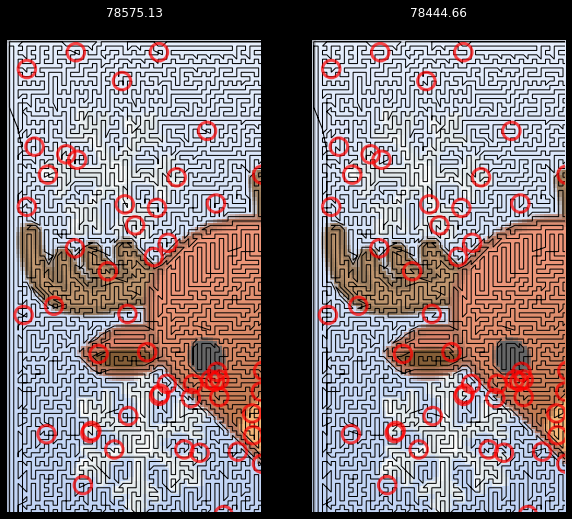

In [ ]:
# Show the differences
# Left path: without local optimization
# Right path: with local optimization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
plot_traj(path.sum(axis=1), image, difference_list, ax1)
plot_traj(optimized_path.sum(axis=1), image, difference_list, ax2)
ax1.set_title(f"{total_cost(path, image):.2f}")
ax2.set_title(f"{total_cost(optimized_path, image):.2f}")
plt.show()

In [ ]:
submit(optimized_path)

0         64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
1        64 -1;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
2        64 -2;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
3        64 -3;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
4        64 -4;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
                            ...                    
66934    64 -2;-32 4;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
66935    64 -1;-32 3;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
66936     64 0;-32 2;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
66937     64 0;-32 1;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
66938     64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
Name: configuration, Length: 66939, dtype: object

Total cost of saved path is 78444.66


# Exercises

1. Find more local optimizations.
2. Apply the optimization algorithm to your own best submission.